# Data Science Capstone

## Comparing Memphis and Portland's access to fitness facilities, and food venues


In [3]:
!conda install -c conda-forge geopy --yes        # if needed
!conda install -c conda-forge folium=0.5.0 --yes # if needed

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

   

In [26]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values



import urllib.request
from bs4 import BeautifulSoup
import requests


from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


# Scraping Wikipedia for Memphis and Portland Neighbourhoods

## Memphis Neighbourhoods

In [27]:
url = 'https://raw.githubusercontent.com/Daylen-Mackey/Data_Science_Capstone/master/MemphisNeighbourhoods.csv'
mNeigh = pd.read_csv(url)
mNeigh.head(20)

,Neighbourhoods
0,Central Business District
1,Edge District
2,Harbor Town
3,Linden
4,Medical District
5,Pinch District
6,South Forum
7,South Main Arts District
8,Speedway Terrace
9,Uptown/Greenlaw


### Some Memphis Neighbourhoods have a '/' in them. Let's split that -- duplicates can be filtered out later

### *Before*


In [28]:
#before
mNeigh.tail()

,Neighbourhoods
102,Fairgrounds
103,Glenview
104,Lamar Avenue
105,Poplar Avenue
106,Union Extended


In [29]:
replicates = mNeigh[mNeigh.Neighbourhoods.str.contains('/')]
replicates

,Neighbourhoods
9,Uptown/Greenlaw
32,Balmoral/Quince
34,Cherry/Willow
37,Galloway Gardens/Walnut Grove


In [30]:
replicates['Neighbourhoods'] = replicates['Neighbourhoods'].apply(lambda x: x.split('/')[1]) 
replicates

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Neighbourhoods
9,Greenlaw
32,Quince
34,Willow
37,Walnut Grove


### Remove the repllicates and append to bottom of data frame

In [31]:
#Keep what's on the left side of the '/'
mNeigh['Neighbourhoods'] = mNeigh['Neighbourhoods'].apply(lambda x: x.split('/')[0]) 


In [32]:
copy = mNeigh
mCopy = pd.concat([copy, replicates])


### *After*


In [33]:

mCopy.reset_index(drop = True, inplace = True)
mCopy.tail(15)

,Neighbourhoods
96,Magnolia
97,Oakhaven
98,Orange Mound
99,Parkway Village
100,Riverdale
101,Southwind
102,Fairgrounds
103,Glenview
104,Lamar Avenue
105,Poplar Avenue


In [34]:
mCopy['Name'] = mCopy['Neighbourhoods'] + ', Memphis, Tennessee'
mCopy.tail()

,Neighbourhoods,Name
106,Union Extended,"Union Extended, Memphis, Tennessee"
107,Greenlaw,"Greenlaw, Memphis, Tennessee"
108,Quince,"Quince, Memphis, Tennessee"
109,Willow,"Willow, Memphis, Tennessee"
110,Walnut Grove,"Walnut Grove, Memphis, Tennessee"


In [35]:
# Meanial Data Cleaning 
mCopy.loc[mCopy['Neighbourhoods'] == 'University Street Neighborhood','Neighbourhoods'] = 'University Street'


In [36]:
geolocator = Nominatim(user_agent="ny_explorer")

mLat = []
mLong = []

for city in mCopy['Name']:
    location = geolocator.geocode(city)
    try:
        mLat.append(location.latitude)
        mLong.append(location.longitude)
    except:
        mLat.append(np.nan)
        mLong.append(np.nan)
    #pLong = pLong.append(location.latitude)

In [37]:
mCopy['Latitude'] = mLat
mCopy['Longitude'] = mLong
#mCopy

## Portland Neighbourhoods

In [38]:
url = 'https://raw.githubusercontent.com/Daylen-Mackey/Data_Science_Capstone/master/PortlandNeighbourhoods.csv'
pNeigh = pd.read_csv(url)
pNeigh.head(15)

,Neighbourhoods
0,Arlington Heights
1,Forest Park
2,Goose Hollow
3,Hillside
4,Linnton
5,"Northwest District (includes Uptown, Nob Hill,..."
6,Northwest Heights
7,Northwest Industrial
8,Old Town Chinatown
9,Pearl District


### Portland Dataframe contains (includes...) many times -- need to remove

In [39]:
pCopy = pNeigh
pCopy['Neighbourhoods'] = pCopy['Neighbourhoods'].apply(lambda x: x.split('(')[0])
pCopy.head(20)

,Neighbourhoods
0,Arlington Heights
1,Forest Park
2,Goose Hollow
3,Hillside
4,Linnton
5,Northwest District
6,Northwest Heights
7,Northwest Industrial
8,Old Town Chinatown
9,Pearl District


In [40]:
pCopy['Name'] = pCopy['Neighbourhoods'] + ', Portland, Oregon'
pCopy.size

190

In [41]:
geolocator = Nominatim(user_agent="ny_explorer")

pLat = []
pLong = []

for city in pCopy.Name:
    location = geolocator.geocode(city)
    try:
            pLat.append(location.latitude)
            pLong.append(location.longitude)
    except:
        pLat.append(np.nan)
        pLong.append(np.nan)
    #pLong = pLong.append(location.latitude)
    

In [42]:
pCopy['Latitude'] = pLat
pCopy['Longitude'] = pLong
pCopy

,Neighbourhoods,Name,Latitude,Longitude
0,Arlington Heights,"Arlington Heights, Portland, Oregon",45.519496,-122.710667
1,Forest Park,"Forest Park, Portland, Oregon",45.561468,-122.758581
2,Goose Hollow,"Goose Hollow, Portland, Oregon",45.517749,-122.692819
3,Hillside,"Hillside, Portland, Oregon",45.527439,-122.713120
4,Linnton,"Linnton, Portland, Oregon",45.600330,-122.786779
5,Northwest District,"Northwest District , Portland, Oregon",45.533013,-122.698845
6,Northwest Heights,"Northwest Heights, Portland, Oregon",45.540806,-122.774354
7,Northwest Industrial,"Northwest Industrial, Portland, Oregon",NaN,NaN
8,Old Town Chinatown,"Old Town Chinatown, Portland, Oregon",45.524934,-122.673516
9,Pearl District,"Pearl District, Portland, Oregon",45.529044,-122.681598


## We now have dataframes with Memphis and Portland' neighbourhood coordinates. Let's remove NaN values, and proceed

In [43]:
pLoc = pCopy.dropna()
pLoc

,Neighbourhoods,Name,Latitude,Longitude
0,Arlington Heights,"Arlington Heights, Portland, Oregon",45.519496,-122.710667
1,Forest Park,"Forest Park, Portland, Oregon",45.561468,-122.758581
2,Goose Hollow,"Goose Hollow, Portland, Oregon",45.517749,-122.692819
3,Hillside,"Hillside, Portland, Oregon",45.527439,-122.713120
4,Linnton,"Linnton, Portland, Oregon",45.600330,-122.786779
5,Northwest District,"Northwest District , Portland, Oregon",45.533013,-122.698845
6,Northwest Heights,"Northwest Heights, Portland, Oregon",45.540806,-122.774354
8,Old Town Chinatown,"Old Town Chinatown, Portland, Oregon",45.524934,-122.673516
9,Pearl District,"Pearl District, Portland, Oregon",45.529044,-122.681598
10,Portland Downtown,"Portland Downtown, Portland, Oregon",45.515274,-122.680025


In [44]:
mLoc = mCopy.dropna()
mLoc

,Neighbourhoods,Name,Latitude,Longitude
1,Edge District,"Edge District, Memphis, Tennessee",35.159758,-90.054260
2,Harbor Town,"Harbor Town, Memphis, Tennessee",35.163899,-90.053486
3,Linden,"Linden, Memphis, Tennessee",35.134818,-90.027293
4,Medical District,"Medical District, Memphis, Tennessee",35.141978,-90.030331
8,Speedway Terrace,"Speedway Terrace, Memphis, Tennessee",35.155645,-90.019813
9,Uptown,"Uptown, Memphis, Tennessee",35.150906,-90.044815
11,Warehouse District,"Warehouse District, Memphis, Tennessee",35.137284,-90.060127
12,Winchester Park,"Winchester Park, Memphis, Tennessee",35.152504,-90.036226
13,Annesdale,"Annesdale, Memphis, Tennessee",35.134008,-90.062926
14,Belleair,"Belleair, Memphis, Tennessee",35.141008,-89.993866


### Hidden Cell -- Connecting to FourSquare API

In [45]:
# The code was removed by Watson Studio for sharing.

### Finding the Coordinates of Portland, Oregon and Memphis, Tennessee

In [46]:
city = 'Portland, Oregon'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city)
portland_latitude = location.latitude
portland_longitude = location.longitude

city = 'Memphis, Tennessee'

location = geolocator.geocode(city)
memphis_latitude = location.latitude
memphis_longitude = location.longitude


print('The geograpical coordinate of Portland are {}, {}.'.format(portland_latitude, portland_longitude))
print('The geograpical coordinate of Memphis are {}, {}.'.format(memphis_latitude, memphis_longitude))

The geograpical coordinate of Portland are 45.5202471, -122.6741949.
The geograpical coordinate of Memphis are 35.1490215, -90.0516285.


# Creating Maps of Portland and Memphis Neighbourhoods

## Portland

In [23]:
map_portland = folium.Map(location=[portland_latitude, portland_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(pLoc['Latitude'], pLoc['Longitude'], pLoc['Neighbourhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_portland)  
map_portland

In [60]:
map_memphis = folium.Map(location=[memphis_latitude, memphis_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(mLoc['Latitude'], mLoc['Longitude'], mLoc['Neighbourhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_memphis)  
map_memphis

In [48]:

pLoc.head()

,Neighbourhoods,Name,Latitude,Longitude
0,Arlington Heights,"Arlington Heights, Portland, Oregon",45.519496,-122.710667
1,Forest Park,"Forest Park, Portland, Oregon",45.561468,-122.758581
2,Goose Hollow,"Goose Hollow, Portland, Oregon",45.517749,-122.692819
3,Hillside,"Hillside, Portland, Oregon",45.527439,-122.713120
4,Linnton,"Linnton, Portland, Oregon",45.600330,-122.786779


In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius = 2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
# Compile all of Portland's Venues
#pVenues
pp = getNearbyVenues(names=pLoc['Neighbourhoods'],
                                   latitudes=pLoc['Latitude'],
                                   longitudes=pLoc['Longitude']
                                  )

#mVenues Compile all of Memphis' Venues
mm = getNearbyVenues(names=mLoc['Neighbourhoods'],
                                   latitudes=mLoc['Latitude'],
                                   longitudes=mLoc['Longitude']
                                  )

In [64]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

#create_download_link(pp)
create_download_link(mm)

# We have all the venue data in the two cities, now let's look through it

## Venue categories to consider: Gyms, Fast Food, Grocery stores, Dollar Stores

## Relevant Forsquare Categories
Gym / Fitness Center
4bf58dd8d48988d175941735

Grocery Store
4bf58dd8d48988d118951735

Health Food Store
50aa9e744b90af0d42d5de0e

Fast Food Restaurant
4bf58dd8d48988d16e941735


## First, we need to remove duplicate values

In [66]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Arlington Heights,45.519496,-122.710667,Portland Japanese Garden,45.519457,-122.706937,Garden
1,1,Arlington Heights,45.519496,-122.710667,Washington Park,45.517835,-122.705784,Park
2,2,Arlington Heights,45.519496,-122.710667,International Rose Test Garden,45.519075,-122.705616,Botanical Garden
3,3,Arlington Heights,45.519496,-122.710667,Hoyt Arboretum,45.517493,-122.717714,Park
4,4,Arlington Heights,45.519496,-122.710667,Shakespeare Garden,45.518558,-122.704684,Garden


In [69]:

body = client_51ec5af4c5934776b115d7e30afb1640.get_object(Bucket='datasciencecapstone-donotdelete-pr-qhpdheulkznwhy',Key='memphisVenues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

mm = pd.read_csv(body)
mm.head()

,Unnamed: 0,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Edge District,35.159758,-90.05426,Little Cafe Eclectic,35.160896,-90.053805,Coffee Shop
1,1,Edge District,35.159758,-90.05426,Miss Cordelia's Grocery,35.161108,-90.053721,Grocery Store
2,2,Edge District,35.159758,-90.05426,The Lookout at the Pyramid,35.156012,-90.052153,American Restaurant
3,3,Edge District,35.159758,-90.05426,Bass Pro Shops At The Pyramid (Bass Pro Shops ...,35.156008,-90.052148,Sporting Goods Shop
4,4,Edge District,35.159758,-90.05426,Tug's,35.160924,-90.055177,American Restaurant


In [74]:
pp.drop(columns = 'Unnamed: 0', inplace = True)
pp.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arlington Heights,45.519496,-122.710667,Portland Japanese Garden,45.519457,-122.706937,Garden
1,Arlington Heights,45.519496,-122.710667,Washington Park,45.517835,-122.705784,Park
2,Arlington Heights,45.519496,-122.710667,International Rose Test Garden,45.519075,-122.705616,Botanical Garden
3,Arlington Heights,45.519496,-122.710667,Hoyt Arboretum,45.517493,-122.717714,Park
4,Arlington Heights,45.519496,-122.710667,Shakespeare Garden,45.518558,-122.704684,Garden


In [76]:
mm.drop(columns = 'Unnamed: 0', inplace = True)
mm.head()

ValueError: labels ['Unnamed: 0'] not contained in axis

## Fewer results for Memphis -- somewhat concerning

In [77]:
pV = pp.drop(['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude'],axis = 1)
print(pV.shape)
print(pp.shape)



(8387, 4)
(8387, 7)


In [78]:
pV.drop_duplicates(inplace = True)
print(pV.shape)
pV[pV['Venue Category'] == 'Fast Food Restaurant']

(2650, 4)


,Venue,Venue Latitude,Venue Longitude,Venue Category
866,McDonald's,45.452881,-122.704404,Fast Food Restaurant
877,Wendy's,45.457160,-122.713136,Fast Food Restaurant
948,Dairy Queen,45.465418,-122.753505,Fast Food Restaurant
964,Carl's Jr.,45.443055,-122.744808,Fast Food Restaurant
1085,Baja Fresh,45.471308,-122.686483,Fast Food Restaurant
1114,Taco Bell,45.468499,-122.692095,Fast Food Restaurant
2406,Jack in the Box,45.580879,-122.661621,Fast Food Restaurant
2467,Carl's Jr.,45.581091,-122.662445,Fast Food Restaurant
2491,Burger King,45.593874,-122.681558,Fast Food Restaurant
2494,McDonald's,45.610161,-122.680597,Fast Food Restaurant


In [79]:
pV.drop_duplicates(inplace = True)
print(pV.shape)
pV[pV['Venue Category'] == 'Fast Food Restaurant']

(2650, 4)


,Venue,Venue Latitude,Venue Longitude,Venue Category
866,McDonald's,45.452881,-122.704404,Fast Food Restaurant
877,Wendy's,45.457160,-122.713136,Fast Food Restaurant
948,Dairy Queen,45.465418,-122.753505,Fast Food Restaurant
964,Carl's Jr.,45.443055,-122.744808,Fast Food Restaurant
1085,Baja Fresh,45.471308,-122.686483,Fast Food Restaurant
1114,Taco Bell,45.468499,-122.692095,Fast Food Restaurant
2406,Jack in the Box,45.580879,-122.661621,Fast Food Restaurant
2467,Carl's Jr.,45.581091,-122.662445,Fast Food Restaurant
2491,Burger King,45.593874,-122.681558,Fast Food Restaurant
2494,McDonald's,45.610161,-122.680597,Fast Food Restaurant


In [80]:
mV = mm.drop(['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude'],axis = 1)
mV.shape


(5434, 4)

In [81]:
mV.drop_duplicates(inplace = True)
print(mV.shape)
mV.head()

(2002, 4)


,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Little Cafe Eclectic,35.160896,-90.053805,Coffee Shop
1,Miss Cordelia's Grocery,35.161108,-90.053721,Grocery Store
2,The Lookout at the Pyramid,35.156012,-90.052153,American Restaurant
3,Bass Pro Shops At The Pyramid (Bass Pro Shops ...,35.156008,-90.052148,Sporting Goods Shop
4,Tug's,35.160924,-90.055177,American Restaurant


# Gym Count

In [82]:
pGyms = pV[pV['Venue Category'] == 'Gym / Fitness Center']
# If there are any college gyms not being considered 
pGyms = pGyms.append(pV[pV['Venue Category'] == 'College Gym']) 

pGyms

,Venue,Venue Latitude,Venue Longitude,Venue Category
27,Multnomah Athletic Club (MAC),45.520244,-122.692190,Gym / Fitness Center
401,barre3 Portland - Pearl,45.530774,-122.681488,Gym / Fitness Center
841,Mt. Park Rec Center,45.431628,-122.715183,Gym / Fitness Center
972,Twist Sport Conditioning Center,45.445920,-122.726716,Gym / Fitness Center
1145,Industrial Barre + Industrial Ride,45.463180,-122.652974,Gym / Fitness Center
1314,Diva Den Studio,45.433518,-122.763031,Gym / Fitness Center
1368,Mittleman Jewish Community Center (MJCC),45.476542,-122.704049,Gym / Fitness Center
2083,24 Hour Fitness,45.489281,-122.651457,Gym / Fitness Center
2331,Pole Palace,45.582242,-122.687651,Gym / Fitness Center
2716,Anytime Fitness,45.626950,-122.676170,Gym / Fitness Center


In [83]:
mGyms = (mV[mV['Venue Category'] == 'Gym / Fitness Center'])
# If there are any college gyms not being considered 
mGyms = mGyms.append(mV[mV['Venue Category'] == 'College Gym']) 

mGyms

,Venue,Venue Latitude,Venue Longitude,Venue Category
31,Envision Memphis,35.143815,-90.051499,Gym / Fitness Center
45,Living Well Center,35.155308,-90.038407,Gym / Fitness Center
233,Planet Fitness,35.142464,-90.006513,Gym / Fitness Center
1434,Cardio Barre,35.136513,-89.991332,Gym / Fitness Center
1841,LA Fitness Oak Court,35.118870,-89.909967,Gym / Fitness Center
2196,LA Fitness,35.205512,-89.767343,Gym / Fitness Center
2285,Pure Barre,35.112397,-89.905006,Gym / Fitness Center
2606,LA Fitness Ridgeway,35.096298,-89.860032,Gym / Fitness Center
2644,24 Hour Fitness,35.096361,-89.859896,Gym / Fitness Center
3948,Planet Fitness (Whitehaven),35.036476,-90.023960,Gym / Fitness Center


## Fast Food Count

In [84]:
pFast = pV[pV['Venue Category'] == 'Fast Food Restaurant']
pFast

,Venue,Venue Latitude,Venue Longitude,Venue Category
866,McDonald's,45.452881,-122.704404,Fast Food Restaurant
877,Wendy's,45.457160,-122.713136,Fast Food Restaurant
948,Dairy Queen,45.465418,-122.753505,Fast Food Restaurant
964,Carl's Jr.,45.443055,-122.744808,Fast Food Restaurant
1085,Baja Fresh,45.471308,-122.686483,Fast Food Restaurant
1114,Taco Bell,45.468499,-122.692095,Fast Food Restaurant
2406,Jack in the Box,45.580879,-122.661621,Fast Food Restaurant
2467,Carl's Jr.,45.581091,-122.662445,Fast Food Restaurant
2491,Burger King,45.593874,-122.681558,Fast Food Restaurant
2494,McDonald's,45.610161,-122.680597,Fast Food Restaurant


In [85]:
mFast = mV[mV['Venue Category'] == 'Fast Food Restaurant']
mFast

,Venue,Venue Latitude,Venue Longitude,Venue Category
185,Wendy's,35.147041,-90.044381,Fast Food Restaurant
286,Arby's,35.137568,-90.029137,Fast Food Restaurant
903,Chick-fil-A,35.135141,-89.995221,Fast Food Restaurant
1172,Sonic Drive-In,35.139313,-89.978509,Fast Food Restaurant
1337,Jack Pirtles Chicken,35.144233,-90.014749,Fast Food Restaurant
1596,Jack Pirtle's Chicken,35.113330,-90.021950,Fast Food Restaurant
1653,McDonald's,35.105258,-89.984569,Fast Food Restaurant
1823,Chick-fil-A,35.117709,-89.937266,Fast Food Restaurant
1850,Chick-fil-A,35.117032,-89.912472,Fast Food Restaurant
2047,Taco Bell,35.129177,-89.949515,Fast Food Restaurant


## Grocery Store Count

In [86]:
pGroc = pV[pV['Venue Category'] == 'Grocery Store']
pGroc.append(pV[pV['Venue Category'] == 'Health Food Store'])

pGroc

,Venue,Venue Latitude,Venue Longitude,Venue Category
7,Zupan's Market,45.523246,-122.698888,Grocery Store
24,Trader Joe's,45.526149,-122.695140,Grocery Store
45,New Seasons Market,45.533840,-122.696006,Grocery Store
81,Food Front Cooperative Grocery NW,45.535542,-122.700311,Grocery Store
274,City Market NW,45.528286,-122.694790,Grocery Store
784,Lamb's at Strohecker's,45.504432,-122.707056,Grocery Store
827,New Seasons Market,45.433765,-122.703136,Grocery Store
830,Barbur World Foods,45.454408,-122.719880,Grocery Store
840,Market of Choice,45.463484,-122.684019,Grocery Store
852,Uncle John's Market,45.462967,-122.690291,Grocery Store


In [87]:
mGroc = mV[mV['Venue Category'] == 'Grocery Store']
mGroc.append(mV[mV['Venue Category'] == 'Health Food Store'])

mGroc.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Miss Cordelia's Grocery,35.161108,-90.053721,Grocery Store
64,City Market Groceries & Deli,35.143218,-90.053324,Grocery Store
473,Mid-Town Mini Mart,35.155154,-89.997365,Grocery Store
907,The Fresh Market,35.133827,-89.989837,Grocery Store
1148,Lit Jr,35.149250,-89.962666,Grocery Store


## Discount Store Count

In [88]:
pDiscount = pV[pV['Venue Category'] == 'Discount Store']
pDiscount

,Venue,Venue Latitude,Venue Longitude,Venue Category
1030,Dollar Tree,45.487539,-122.745165,Discount Store
1324,Dollar Tree,45.434624,-122.766502,Discount Store
2437,Dollar Tree,45.594953,-122.678166,Discount Store
2540,Dollar Tree,45.588674,-122.746151,Discount Store
4871,Dollar Tree,45.488050,-122.593404,Discount Store
6701,Dollar Tree,45.534754,-122.536475,Discount Store
6702,Dollar Tree,45.558695,-122.552525,Discount Store
6739,Dollar Tree,45.505179,-122.474805,Discount Store
6824,Dollar Tree,45.533200,-122.478510,Discount Store
7019,Dollar Tree,45.490545,-122.577392,Discount Store


In [89]:
mDiscount = mV[mV['Venue Category'] == 'Discount Store']
mDiscount

,Venue,Venue Latitude,Venue Longitude,Venue Category
180,Family Dollar,35.164138,-90.036981,Discount Store
295,Dollar Tree,35.128585,-90.020309,Discount Store
1121,Dollar Tree,35.130844,-89.946482,Discount Store
1173,Dollar General,35.125949,-89.980043,Discount Store
1174,Dollar Tree,35.118350,-89.985039,Discount Store
1176,Dollar Tree,35.145741,-89.961282,Discount Store
1183,Family Dollar,35.107728,-89.963211,Discount Store
1333,Family Dollar,35.160986,-90.001214,Discount Store
1354,Family Dollar,35.151030,-89.979527,Discount Store
1632,Dollar General,35.107247,-89.988051,Discount Store


## Let's Create a Dataframe with all the Final Data

In [90]:
cities = ['Portland', 'Memphis']
pData = [len(pGyms), len(pFast), len(pGroc), len(pDiscount)]
mData = [len(mGyms), len(mFast), len(mGroc), len(mDiscount)]

data = [pData,mData]

finalData = pd.DataFrame(np.array(data),
                                  columns=['Fitness Centres', 'Fast Food Restaurants', 'Grocery Stores', 'Discount Stores'], 
                                  index = cities)

finalData

,Fitness Centres,Fast Food Restaurants,Grocery Stores,Discount Stores
Portland,20,36,54,11
Memphis,17,104,36,93


## Visualization Time


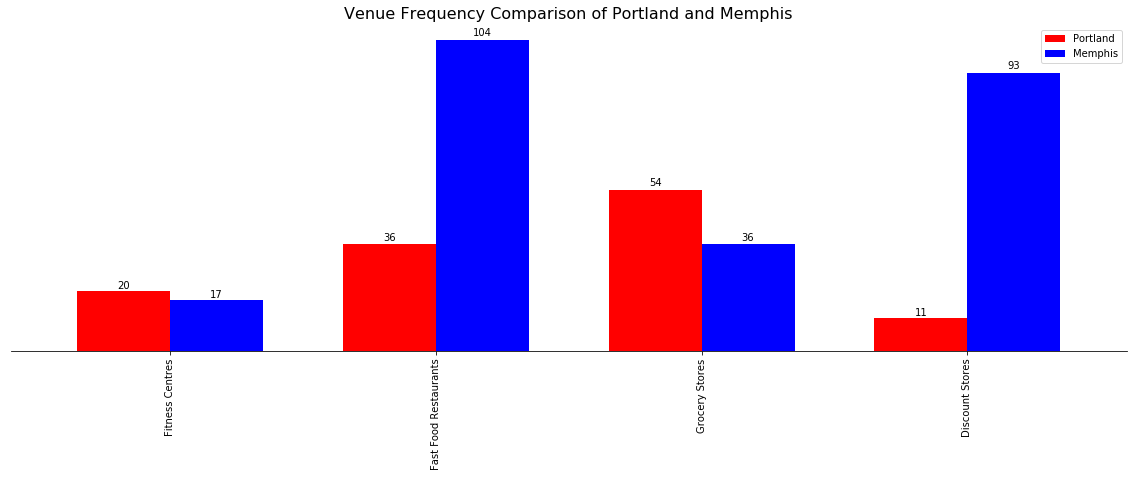

In [94]:
df_plot = finalData.T

ax = df_plot.plot(kind = 'bar', figsize = (20,6), width = 0.7, color = ['red', 'blue', '#d9534f'])


#ax.set_xlabel('Category', fontsize = 14) # add to x-label to the plot
#ax.set_ylabel('Percentage') # add y-label to the plot
ax.set_title('Venue Frequency Comparison of Portland and Memphis', fontsize = 16) # add title to the plot

rects = ax.patches

# Make some labels.

# Autolabel code from https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                height,
                ha='center', va='bottom')
        

autolabel(rects)

# Removing Borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Remove y axis
ax.axes.get_yaxis().set_visible(False)

plt.show()



# While this is nice, it doesn't account for the *number* of venues in each city 

In [96]:
mAdj = []
pAdj = []
for data in mData:
    mAdj.append(data / len(mV) * 100)
for data in pData:
    pAdj.append(data / len(pV) * 100)

    

dataAdj = pd.DataFrame([pAdj, mAdj],
                                  columns=['Fitness Centres', 'Fast Food Restaurants', 'Grocery Stores', 'Discount Stores'], 
                                  index = cities)

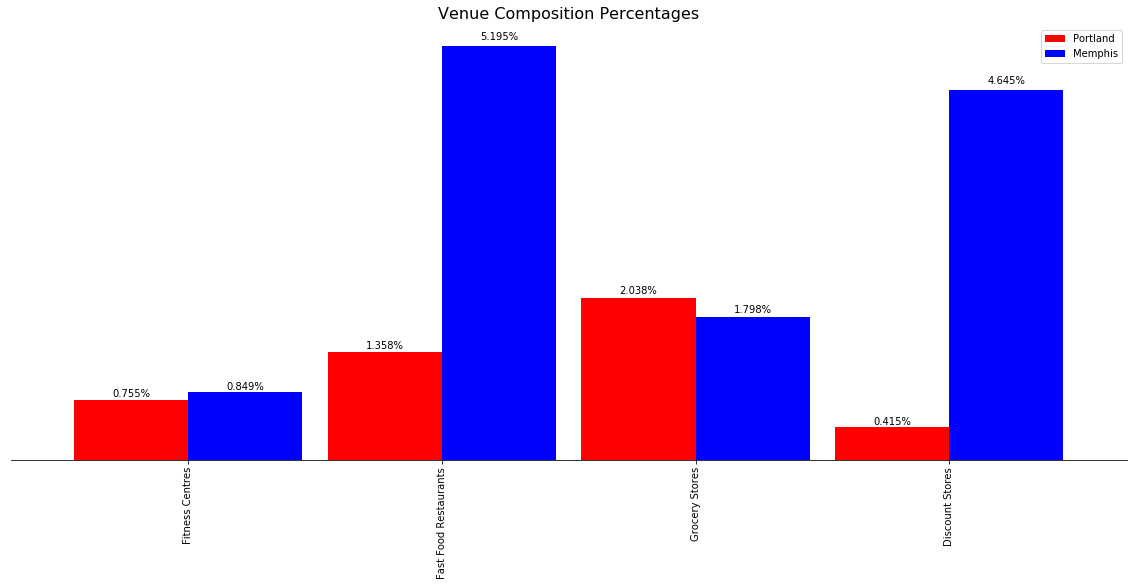

In [97]:
df_plot = dataAdj.T

ax = df_plot.plot(kind = 'bar', figsize = (20,8), width = 0.9, color = ['red', 'blue', '#d9534f'])


#ax.set_xlabel('Category', fontsize = 14) # add to x-label to the plot
#ax.set_ylabel('Percentage') # add y-label to the plot
ax.set_title('Venue Composition Percentages', fontsize = 16) # add title to the plot

rects = ax.patches

# Make some labels.

# Autolabel code from https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                str(round(height, 3)) + '%' ,
                ha='center', va='bottom')
        

autolabel(rects)

# Removing Borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Remove y axis
ax.axes.get_yaxis().set_visible(False)

plt.show()


## Now that we've adjusted for the number of venues located, we can see that there isn't a very large difference between the number of Grocery Stores, or Fitness Centres, but the Fast Food Restaurants and Discount Stores are much more common in Memphis

## Z Score Calculations for 2 Population Proportions

In [103]:
print(len(pV))
print(len(mV))


2650
2002


In [104]:
# input the data from our final dataframe
finalData

,Fitness Centres,Fast Food Restaurants,Grocery Stores,Discount Stores
Portland,20,36,54,11
Memphis,17,104,36,93


## Calculated using https://www.socscistatistics.com/tests/ztest/default2.aspx with a significance level of .05

### Fitness Centres: The value of z is -0.359. The value of p is .35942. The result is not significant at p < .05.

### Fast Food Restaurants The value of z is -7.583. The value of p is < .00001. The result is significant at p < .05.

### Grocery Stores: The value of z is 0.5873. The value of p is .2776. The result is not significant at p < .05.

### Discount Stores: The value of z is -9.6631. The value of p is < .00001. The result is significant at p < .05.

## Plotting the data on a map may reveal something

In [100]:
# add markers to map
def add_markers(maps,venues,colorstr):
    for lat, lng, label in zip(venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color=colorstr,
            fill=True,
            fill_color=colorstr,
            fill_opacity=0.7,
            parse_html=False).add_to(maps)  

In [101]:
map_memphis_venues = folium.Map(location=[memphis_latitude, memphis_longitude], zoom_start=11)

add_markers(map_memphis_venues,mGroc, 'green')
add_markers(map_memphis_venues,mFast, 'black')
add_markers(map_memphis_venues,mGyms, 'purple')
add_markers(map_memphis_venues,mDiscount, 'yellow')


map_memphis_venues

In [102]:
map_portland_venues = folium.Map(location=[portland_latitude, portland_longitude], zoom_start=11)

add_markers(map_portland_venues,pGroc, 'green')
add_markers(map_portland_venues,pFast, 'black')
add_markers(map_portland_venues,pGyms, 'purple')
add_markers(map_portland_venues,pDiscount, 'yellow')


map_portland_venues

## Initial Remarks
### We can see that most venues in both citiers lie along major streets. What's most glaringly obvious is the difference in discount stores (yellow)